Tiny ImageNet dataset consists of 200 categories and each category has 500 of 64x64 size images in training set.

In [2]:
# SIFT
!pip install opencv-contrib-python==4.4.0.44
# restart runtime !

     |████████████████████████████████| 55.7 MB 48 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## Load Tiny ImageNet DataSet

In [107]:
from google.colab import drive

drive.mount( '/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

fatal: destination path 'IMagenet' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


## Extract test and training data from Tiny ImageNet DataSet

In [131]:
import time
import scipy.ndimage as nd
import numpy as np
from imageio import imread

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imread( path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 49.70813226699829 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


## Shuffle and resize training data

In [132]:
def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]
  
train_data, train_labels = shuffle_data(train_data, train_labels)
train_data, train_labels = train_data[:1000], train_labels[:1000]
_train_data = train_data.copy()
_train_labels = train_labels.copy()

In [133]:
image_nr=100
print(train_data[image_nr])
print(train_labels[image_nr])

[[[190 135  94]
  [190 135  94]
  [189 136  94]
  ...
  [160 114  81]
  [164 115  83]
  [166 117  85]]

 [[190 135  94]
  [190 135  94]
  [190 137  95]
  ...
  [161 115  82]
  [165 116  84]
  [166 117  84]]

 [[190 136  92]
  [191 137  93]
  [190 137  95]
  ...
  [162 116  83]
  [166 117  85]
  [167 118  85]]

 ...

 [[ 17  16  22]
  [ 17  16  22]
  [ 15  14  20]
  ...
  [111  46  18]
  [100  43  24]
  [ 89  37  23]]

 [[ 17  16  22]
  [ 18  17  23]
  [ 16  15  21]
  ...
  [ 93  40  24]
  [ 77  34  27]
  [ 65  27  26]]

 [[ 17  16  22]
  [ 20  19  25]
  [ 18  17  23]
  ...
  [ 79  32  22]
  [109  73  73]
  [132 103 108]]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

##Useful functions and imports

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import cv2
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def create_vectorizer(train_data, *kwargs, max_features=1):
    vectorizer = CountVectorizer(max_features=max_features)
    res        = [vectorizer]
    res.append(vectorizer.fit_transform(train_data).toarray())
    for arg in kwargs:
        res.append(vectorizer.transform(arg).toarray())
    return res

def int_labels(labels):
    l = []
    for label in labels:
      for j in range(len(label)):
        if label[j]==1:
          l.append(j)
          break
    return l

scaler = None
def create_scaling(X):
    global scaler
    scaler = StandardScaler().fit(X)

def remove_outlyers(data, label, threshold=100):
    mask = (data>threshold).sum(axis=1)==0
    print("removing {} rows\n".format(np.sum(~mask)))
    return [data[mask], label.drop(label.index[~mask])]

def create_knn(train_data, target, **kwargs):
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(train_data, target )
    return clf

def create_perceptron(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(Perceptron(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = Perceptron(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_rnd_forrest(train_data, target, grid=[], **kwargs):
    if grid != []:
        clf = GridSearchCV(RandomForestClassifier(), grid, refit = True, verbose = 3,n_jobs=2)
    else:
        clf = RandomForestClassifier(**kwargs)
    clf.fit(train_data, target)
    return clf

def create_nb(train_data, target, **kwargs):
    clf =MultinomialNB( **kwargs)
    clf.fit(train_data , target)
    return clf
    
def _create_MLP(input_dim):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(input_dim,)))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(200, activation="softmax"))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

def create_MLP(X_train, y_train):
    
    mlp = KerasClassifier(build_fn=(lambda: _create_MLP(X_train.shape[1])), epochs=15, batch_size=32, verbose=0)
    mlp.fit(X_train, np_utils.to_categorical(y_train))
    return mlp

def plot_confusion_matrix_MLP(mlp, X_test, y_test):
    y_pred = mlp.predict(X_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.title('Multi-layer perceptron confusion matrix')
    plt.show()
    
def get_metrics(algo, test_data, test_target, train_data, train_target):
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)

    return classification_report(test_target, pred_test,output_dict=True),\
           classification_report(train_target, pred_train,output_dict=True)

plt.rcParams['figure.figsize'] = [10,7]

def plot_confusion_matrix_TIN(cm,
                          title='Confusion matrix',
                          cmap=plt.cm.jet,
                          saveas="confmat"):
    figure = plt.figure(1, figsize= (8, 8))
    ticks=[0, 50, 100, 150, 199]
    plt.imshow(cm, interpolation='none',cmap=cmap)
    plt.clim(0, 50)
    plt.colorbar()
    plt.xticks(ticks,fontsize=16)
    plt.yticks(ticks,fontsize=16)
    plt.tight_layout()
    plt.title(title,fontsize=16)
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    figure.savefig(saveas+".pdf", bbox_inches='tight')
    plt.show()

def analyze_predictions_TIN(cm):
    TP_order = np.argsort(cm.diagonal())
    #dt = pd.read_csv('./data/tiny-imagenet-200/words.txt', index_col=0, skiprows=1, sep='\t',).T
    #labels = []
    #for key in test_gen.class_indices.keys():
    #    labels.append(dt[key][0].split(",")[0])
    labels = np.zeros((1000,))

    print("\n least correct predictions")
    df_wrong = pd.DataFrame(zip(labels[TP_order[:10]], cm.diagonal()[TP_order[:10]]),
                   columns =['label', 'times correct predicted'])
    display(df_wrong)

    print("\n most correct predictions, labels, times correct predicted:")
    df_correct = pd.DataFrame(zip(labels[TP_order[-10:]], cm.diagonal()[TP_order[-10:]]),
                   columns =['label', 'times correct predicted'])
    display(df_correct)

    print("\n most confused labels:")
    cm_nodiag = cm-np.diag(cm.diagonal())
    ind = np.unravel_index(np.argsort(cm_nodiag, axis=None), cm_nodiag.shape)
    conf_labels = []
    for n in range(1,11):
        conf_labels.append([cm_nodiag[ind[0][-n],ind[1][-n]], labels[ind[0][-n]], labels[ind[1][-n]] ])
    df_conf = pd.DataFrame(conf_labels,
                   columns =['times confused', 'actual label', 'predicted label'])
    display(df_conf)

    print("\n biggest std for column (for which classes the cnn was not very percice):")
    ind_std = np.argsort(  (cm_nodiag + np.diag(cm_nodiag.mean(axis=0))).std(axis=0) )
    df_unsure = pd.DataFrame(labels[ind_std[-10:]],
                   columns =['times label']).T
    display(df_unsure)

In [151]:
times = {}
times_prepro = {}
times_test = {}

#Histograms

(256, 1)


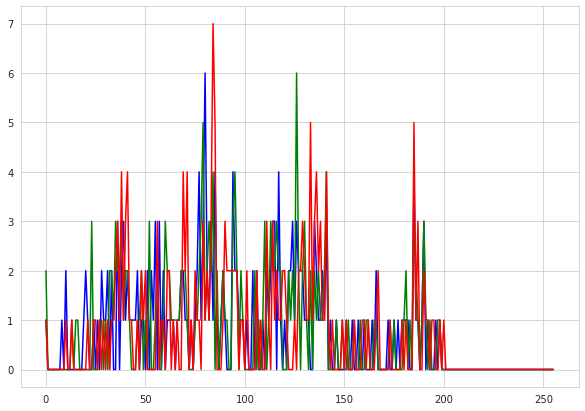

In [152]:
#Example of RGB histogram plot
images = train_data[image_nr]
channels = [0] # [1] or [2] for green or red 0 is blue
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].
hist_blue=cv2.calcHist(images, channels, mask, histSize, ranges)
hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
#plt.plot(hist_blue, hist_green, hist_red)
plt.plot(hist_blue, color= 'blue')
plt.plot(hist_green, color= 'green')
plt.plot(hist_red , color ='red')
print(hist_green.shape)

In [153]:
mask= None
histSize = [256] # Number of bins, forr full scale take 256
ranges= [0,256] # this is our RANGE. Normally, it is [0,256].

times_prepro['histogram'] = time()
data=[]
for i in range(0,len(train_data)):
    hist=np.empty((0,0))
    images = train_data[i]
    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_blue=cv2.calcHist(images, [0], mask, histSize, ranges)
    hist_green=cv2.calcHist(images, [1], mask, histSize, ranges)
    hist_red=cv2.calcHist(images, [2], mask, histSize, ranges)
    hist = np.append(hist, hist_blue)
    hist = np.append(hist, hist_green)
    hist = np.append(hist, hist_red)
    featureVector=hist
    #if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
    #    print("Unexpected length of feature vector: " + i)
    data.append((featureVector))
np_data=np.array(data)
print(np_data.shape)
times_prepro['histogram'] = time() - times_prepro['histogram']

(1000, 768)


In [154]:
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

dataOpenCV_1D_test=[]
dataOpenCV_2D_test=[]
dataOpenCV_3D_test=[]

times_prepro['histogram 1D'] = time()

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for i in range(0,len(train_data)):
    featuresOpenCV_1D = []
    #hist=np.empty((0,0))
    images = train_data[i]
    
    channels= ([0], [1], [2])
    color = ("b", "g", "r")
    
    histSize_1d=[64] 
    featuresOpenCV_1D = []
    for (channels, color) in zip(channels,color):
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
        hist_opencv=cv2.calcHist(images, channels, mask, histSize_1d, ranges)
        featuresOpenCV_1D=np.append(featuresOpenCV_1D, hist_opencv)
    featureVectorOpenCV_1D = featuresOpenCV_1D
    dataOpenCV_1D.append(featureVectorOpenCV_1D) 
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_1D=np.array(dataOpenCV_1D)
times_prepro['histogram 1D'] = time() - times_prepro['histogram 1D']

#print(data)
print(np_dataOpenCV_1D.shape)
print(np_dataOpenCV_1D)

(1000, 192)
[[  0.   0.   0. ...  27.  30.  32.]
 [158.   3.   4. ...   0.   0.   0.]
 [  0.   0.   0. ...   8.  13. 132.]
 ...
 [  0.   0.   0. ...   0.   0. 192.]
 [  1.   0.   1. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [155]:
dataOpenCV_2D=[]
dataOpenCV_2D_test=[]

times_prepro['histogram 2D'] = time()

for i in range(0,len(train_data)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = train_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_2d= 16 
    featuresOpenCV_2D = []
        
        # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
        # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
        #imagePIL = imagePIL.convert('RGB')   
        #images = imagePIL.convert('RGB') 
    hist_opencv_2d_1 = cv2.calcHist(images,  [0,1], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_2 = cv2.calcHist(images,  [0,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    hist_opencv_2d_3 = cv2.calcHist(images,  [1,2], mask, [histSize_2d, histSize_2d], [0, 256, 0, 256])
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_1)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_2)
    featuresOpenCV_2D= np.append(featuresOpenCV_2D, hist_opencv_2d_3)
    featureVectorOpenCV_2D = featuresOpenCV_2D # and append this to our feature vector
    dataOpenCV_2D.append(featureVectorOpenCV_2D) # now we append the feature vector to the dataset so far
    
    #if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
    #    print "Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + i
    
np_dataOpenCV_2D= np.array(dataOpenCV_2D)
times_prepro['histogram 2D'] = time() - times_prepro['histogram 2D']

#print(data)
print(np_dataOpenCV_2D.shape)
print(np_dataOpenCV_2D)

(1000, 768)
[[  0.   0.   0. ...   0.   6.  91.]
 [167.   3.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   1.   7. 161.]
 ...
 [  0.   0.   0. ...   0.   0. 192.]
 [  0.   2.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [156]:
dataOpenCV_3D=[]
dataOpenCV_3D_test=[]

times_prepro['histogram 3D'] = time()

for i in range(0,len(train_data)):
    featuresOpenCV_2D = []
    #hist=np.empty((0,0))
    images = train_data[i]
    
    channels= [[0], [1], [2]]
    color = ("b", "g", "r")
    
    histSize_3d= 8 
    featuresOpenCV_3D = []

    #imagePIL = imagePIL.convert('RGB')   
    #images = imagePIL.convert('RGB') 
    hist_opencv_3d = cv2.calcHist(images,  [0,1,2], mask, [histSize_3d, histSize_3d,histSize_3d ], [0, 256, 0, 256,  0, 256])
    featuresOpenCV_3D= np.append(featuresOpenCV_2D, hist_opencv_3d)
    featureVectorOpenCV_3D = featuresOpenCV_3D # and append this to our feature vector
    dataOpenCV_3D.append(featureVectorOpenCV_3D) # now we append the feature vector to the dataset so far
 
np_dataOpenCV_3D = np.array(dataOpenCV_3D)
times_prepro['histogram 3D'] = time() - times_prepro['histogram 3D']

print(np_dataOpenCV_3D.shape)
print(np_dataOpenCV_3D)

(1000, 512)
[[  0.   0.   0. ...   0.   5. 139.]
 [177.   3.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   1. 191.]
 ...
 [  0.   0.   0. ...   0.   0. 192.]
 [  0.   4.   4. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


#Classification

ppn trained


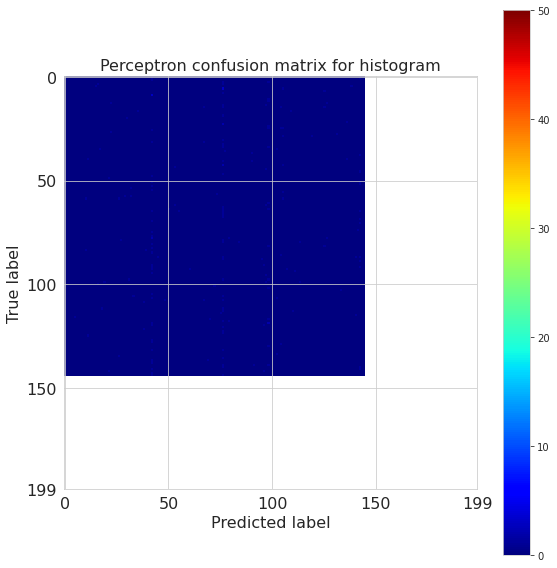


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,3,0.0,0.0
1,3,0.0,0.0
2,2,0.0,0.0
3,2,0.0,0.0
4,2,0.0,0.0
5,2,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


nb trained


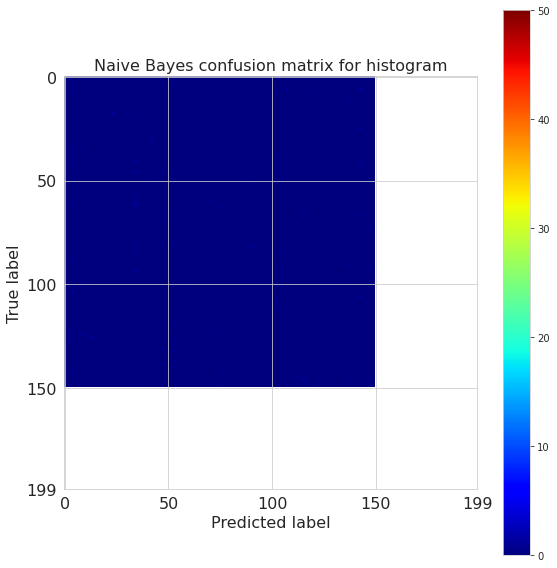


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rndf trained


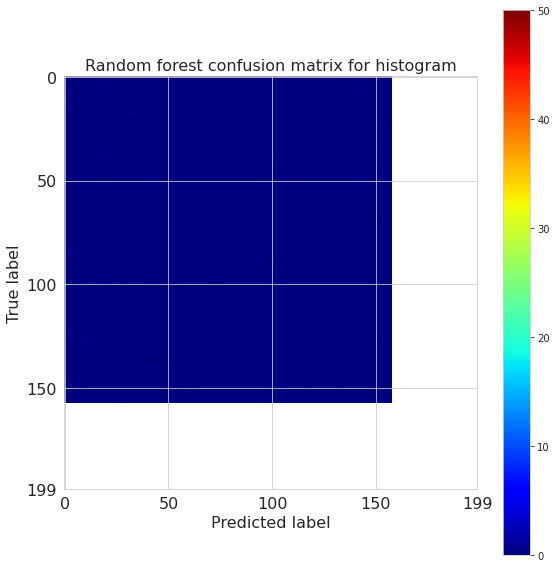


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


mlp trained


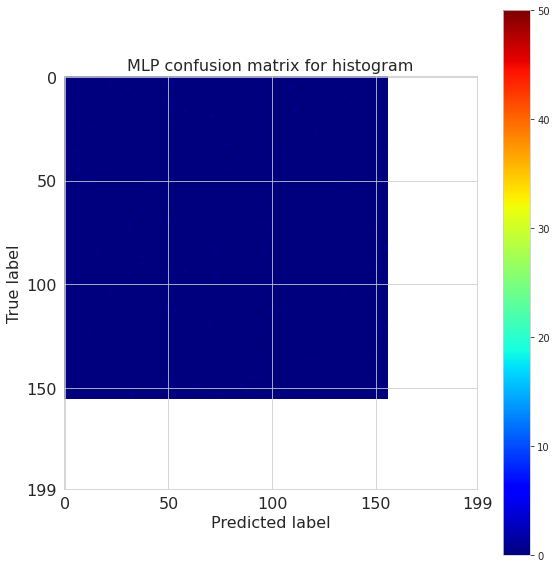


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ppn trained


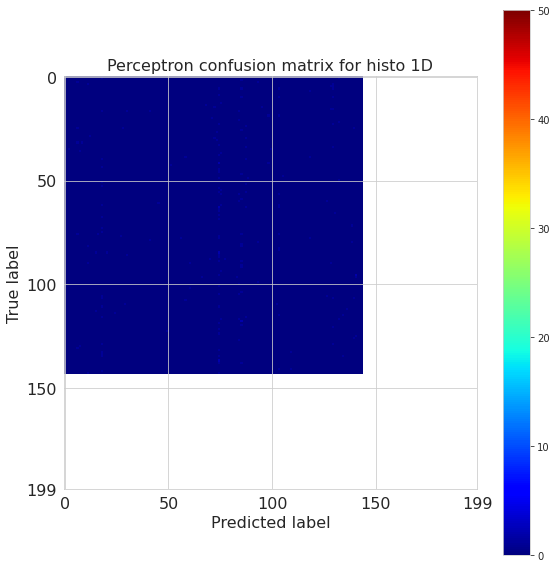


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,2,0.0,0.0
4,2,0.0,0.0
5,2,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


nb trained


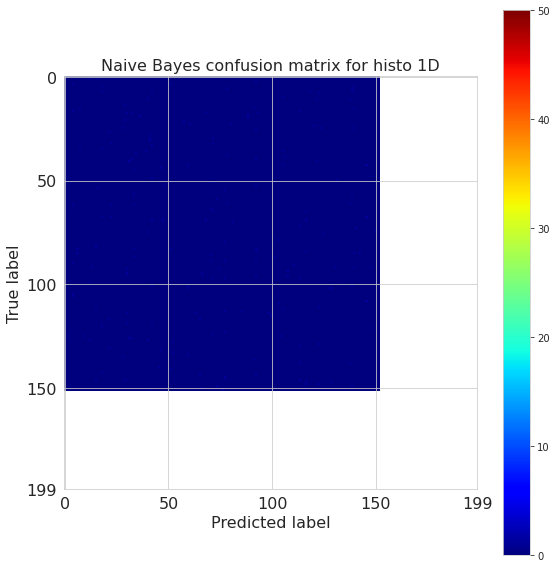


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rndf trained


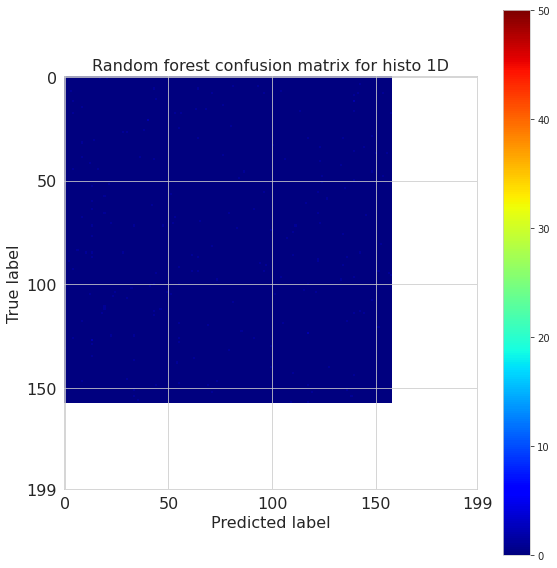


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,2,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


mlp trained


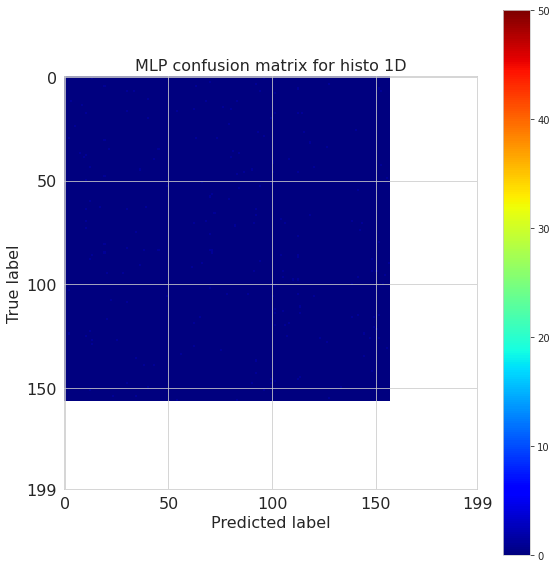


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ppn trained


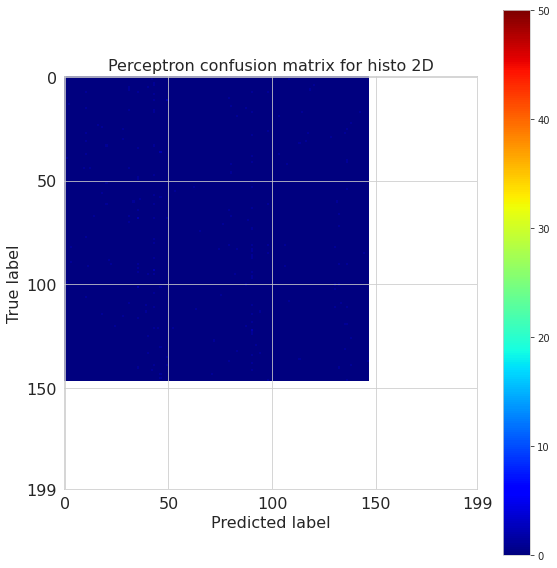


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,2,0.0,0.0
4,2,0.0,0.0
5,2,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


nb trained


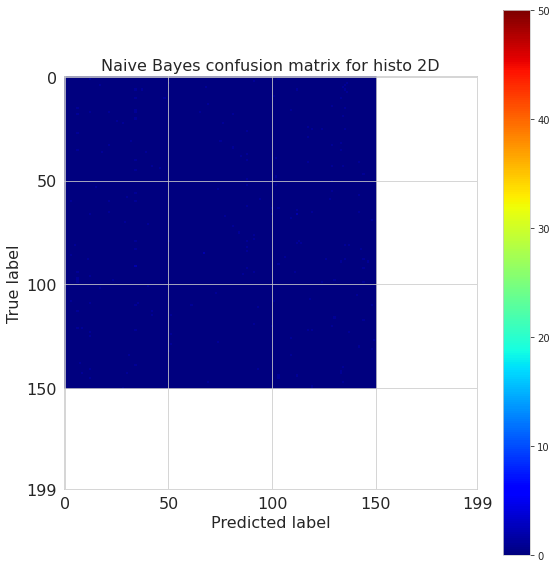


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rndf trained


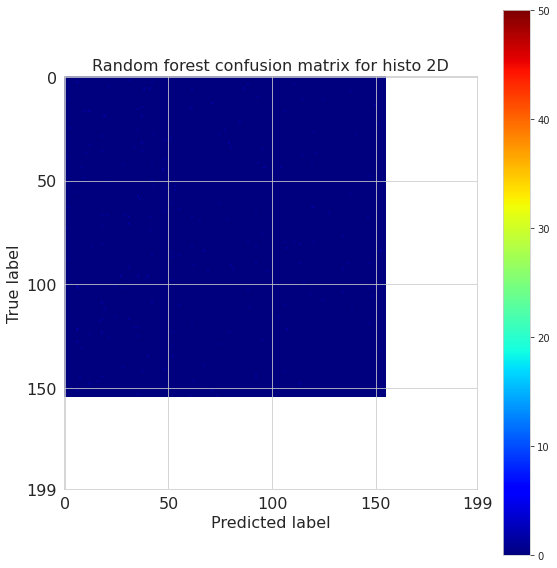


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


mlp trained


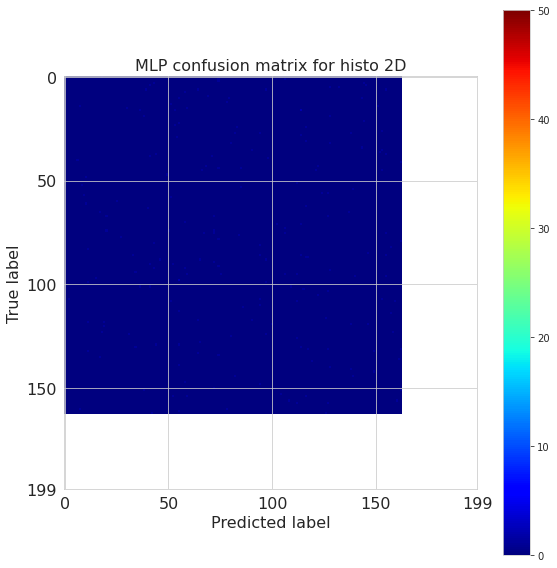


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ppn trained


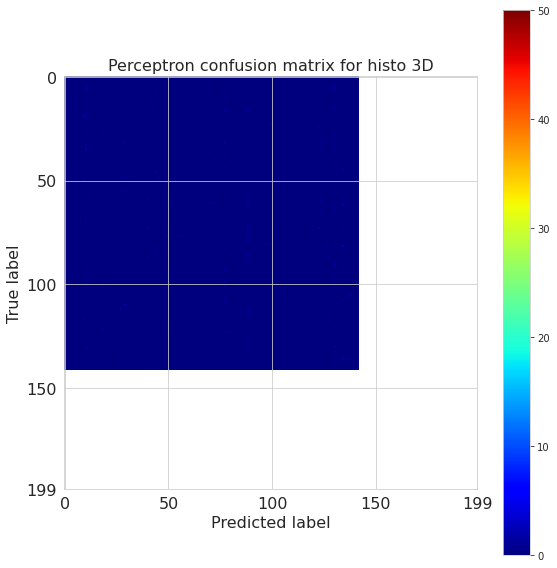


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,2,0.0,0.0
4,2,0.0,0.0
5,2,0.0,0.0
6,2,0.0,0.0
7,2,0.0,0.0
8,2,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


nb trained


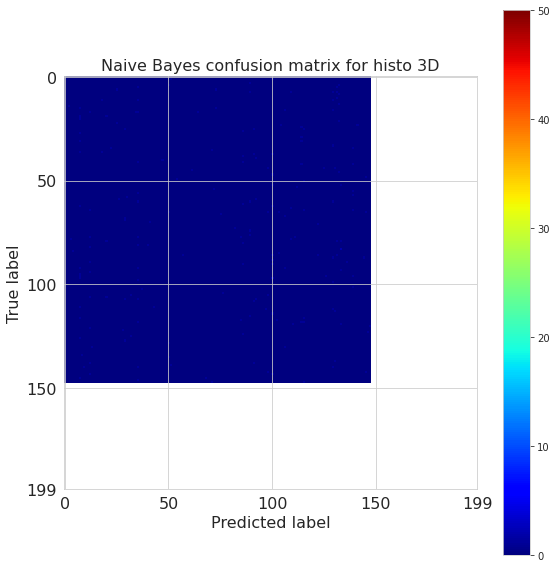


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


rndf trained


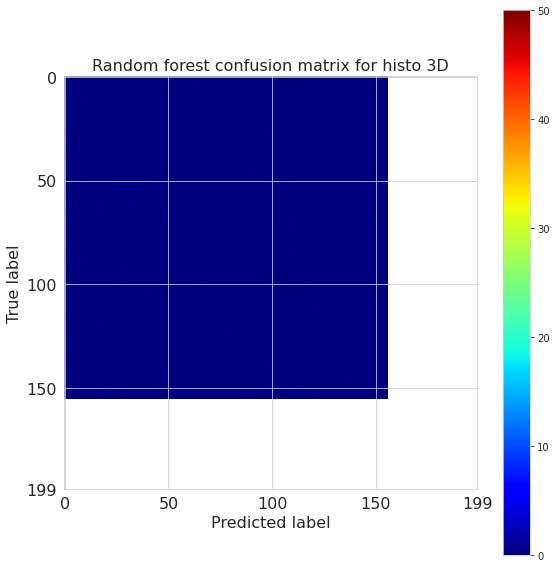


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


mlp trained


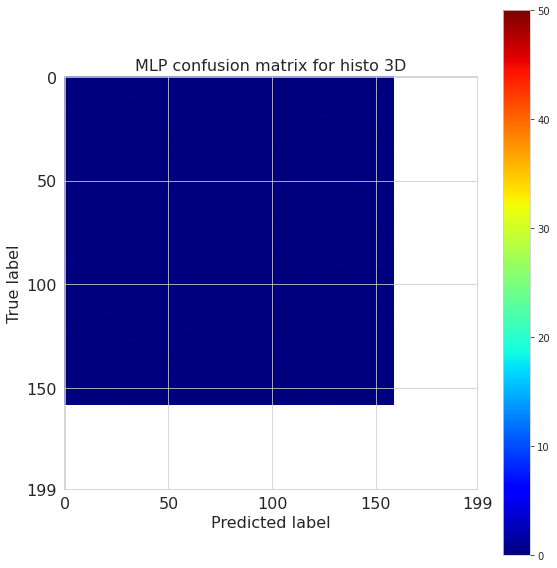


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0.005, 0.005, 0.01, 0.015]
[0.01, 0.01, 0.0, 0.0]
[0.005, 0.0, 0.015, 0.005]
[0.0, 0.005, 0.0, 0.005]


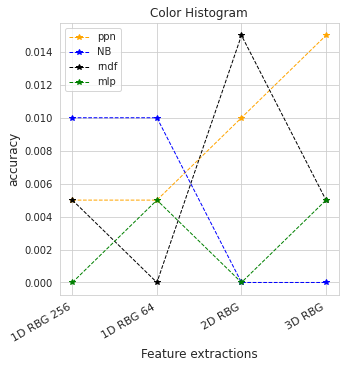

In [157]:
def calc_score_MLP(mlp, X, Y, cv, epochs, batch_size):
    kfold = KFold(n_splits=cv, shuffle=True)
    acc_per_fold = []
    for train, test in kfold.split(X, Y):
        train_data = np.take(X, train, 0)
        train_target = np.take(Y, train, 0)
        test_data = np.take(X, test, 0)
        test_target = np.take(Y, test, 0)
        history = mlp.fit(train_data, np_utils.to_categorical(train_target), batch_size=batch_size, epochs=epochs, verbose=0)
        y_pred = mlp.predict(test_data)
        #print(y_pred)
        score = accuracy_score(y_pred, test_target)
        acc_per_fold.append(score)
    return np.array(acc_per_fold)

# Classification
import warnings
warnings.filterwarnings('ignore')

# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [np_data, np_dataOpenCV_1D, np_dataOpenCV_2D, np_dataOpenCV_3D]
labelTrainingSet = ['histogram', 'histo 1D', 'histo 2D', 'histo 3D']
vals      = trainingSets
trainingLabel=int_labels(train_labels)
scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []

for i in range(len(vals)):
    X_train, X_test, y_train, y_test = train_test_split(vals[i], trainingLabel, test_size=0.2, random_state=42)

    times['histo ppn'] = time()
    ppn = create_perceptron(X_train, y_train)
    times['histo ppn'] = time() - times['histo ppn']
    print('ppn trained')
    y_pred = ppn.predict(X_test)
    scores_ppn.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Perceptron confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__ppn_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['histo nb'] = time()
    nb = create_nb(X_train, y_train)
    times['histo nb'] = time() - times['histo nb']
    print('nb trained')
    y_pred = nb.predict(X_test)
    scores_NB.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Naive Bayes confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__nb_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['histo rndf'] = time()
    rndf = create_rnd_forrest(X_train, y_train)
    times['histo rndf'] = time() - times['histo rndf']
    print('rndf trained')
    y_pred = rndf.predict(X_test)
    scores_rndf.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Random forest confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__rndf_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times_prepro['scaling'] = time()
    create_scaling(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
    times_prepro['scaling'] = time() - times_prepro['scaling']

    times['histo mlp'] = time()
    mlp = create_MLP(X_train, y_train)
    times['histo mlp'] = time() - times['histo mlp']
    print('mlp trained')
    y_pred = mlp.predict(X_test)
    scores_mlp.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='MLP confusion matrix for ' + str(labelTrainingSet[i]),
                          saveas="./CM__mlp_"+str(labelTrainingSet[i]))
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))
        
print(scores_ppn)
print(scores_NB)
print(scores_rndf)
print(scores_mlp)

Nr_data = np.arange(4)
plt.figure(figsize=(5,5))
plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.legend(loc="best")
plt.title("Color Histogram",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.xlabel("Feature extractions",fontsize=12)
labels =["1D RBG 256", "1D RBG 64", "2D RBG", "3D RBG"]
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./Accuracy_color_hist.pdf")

#Bag of words

In [172]:
Image_grey=cv2.cvtColor(train_data[0], cv2.COLOR_BGR2GRAY)
print(train_data[0])

[[[217 218 223]
  [216 217 222]
  [216 217 222]
  ...
  [253 254 255]
  [244 245 247]
  [237 238 240]]

 [[204 205 210]
  [206 207 212]
  [208 209 214]
  ...
  [254 255 255]
  [248 249 251]
  [241 242 244]]

 [[190 191 196]
  [194 195 200]
  [199 200 205]
  ...
  [254 255 255]
  [249 250 252]
  [244 245 247]]

 ...

 [[152 153 157]
  [151 152 156]
  [149 150 154]
  ...
  [140 141 145]
  [128 129 133]
  [139 140 144]]

 [[153 154 158]
  [151 152 156]
  [150 151 155]
  ...
  [137 138 142]
  [122 123 127]
  [135 136 140]]

 [[151 152 156]
  [149 150 154]
  [147 148 152]
  ...
  [150 151 155]
  [137 138 142]
  [153 154 158]]]


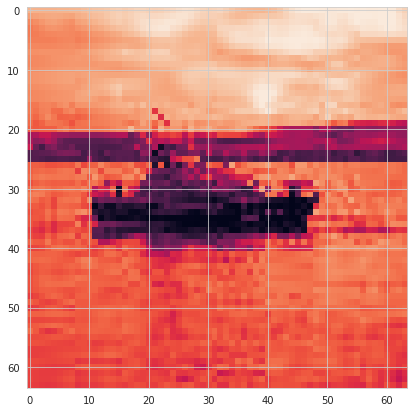

In [173]:
plt.imshow(Image_grey)

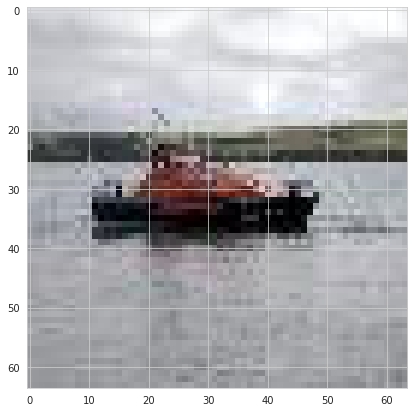

In [174]:
plt.imshow(train_data[0])

In [175]:
# SIFT
import cv2
print (cv2.__version__)
sift=cv2.SIFT_create()

# example of descriptors
keypoints, descriptors = sift.detectAndCompute(train_data[0], None)
keypoints, descriptors.astype('float64')

4.4.0


([<KeyPoint 0x7fcedf5cfed0>,
  <KeyPoint 0x7fcedf5cf300>,
  <KeyPoint 0x7fcedf5cfb10>,
  <KeyPoint 0x7fcedf5cfcc0>,
  <KeyPoint 0x7fcedf5cfc60>,
  <KeyPoint 0x7fcedf5cf810>,
  <KeyPoint 0x7fcedf5cf180>,
  <KeyPoint 0x7fcedf5cfbd0>,
  <KeyPoint 0x7fcedf5cf150>,
  <KeyPoint 0x7fcedf5cf1b0>,
  <KeyPoint 0x7fcedf5cf090>,
  <KeyPoint 0x7fcedf5cfb40>,
  <KeyPoint 0x7fcedf5cfa80>,
  <KeyPoint 0x7fcedf5cf330>,
  <KeyPoint 0x7fcedf5cf390>,
  <KeyPoint 0x7fcedf5cfb70>,
  <KeyPoint 0x7fcedf5cff00>,
  <KeyPoint 0x7fcedf5cf5a0>,
  <KeyPoint 0x7fcec6d9d7e0>,
  <KeyPoint 0x7fcec6d9d120>,
  <KeyPoint 0x7fcec6d9d5a0>,
  <KeyPoint 0x7fcec6d9d030>,
  <KeyPoint 0x7fcec6d9d510>,
  <KeyPoint 0x7fcec6d9d570>,
  <KeyPoint 0x7fcec6d9d420>,
  <KeyPoint 0x7fcec6d9d300>,
  <KeyPoint 0x7fcec6d9d480>],
 array([[  3.,   1.,   0., ...,   8.,   7.,  17.],
        [ 29.,   1.,   0., ...,  13.,   2.,   0.],
        [  2.,   1.,   0., ...,   2.,   1.,   0.],
        ...,
        [100.,   5.,   0., ...,   0.,   0.,   1.],

In [176]:
# resize
X, Y = [], []
X_train = _train_data
y_train = _train_labels

time_sift_bow = time()
# extract descriptors
descriptor_list = []
for i in range(len(X_train)):
    keypoints, descriptors = sift.detectAndCompute(X_train[i], None)
    if descriptors is None:
        plt.imshow(X_train[i])
    else:
        descriptor_list.append(descriptors.astype('float64'))
        X.append(X_train[i])
        Y.append(y_train[i])

X_train = np.array(X)
y_train = np.array(Y)
input_size = len(X_train)

In [177]:
descriptor_vstack = np.array(descriptor_list[0])
for remaining in descriptor_list[1:]:
    descriptor_vstack = np.vstack((descriptor_vstack, remaining))
descriptor_vstack

array([[ 3.,  1.,  0., ...,  8.,  7., 17.],
       [29.,  1.,  0., ..., 13.,  2.,  0.],
       [ 2.,  1.,  0., ...,  2.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3.,  4.,  4.],
       [40.,  0.,  0., ...,  3.,  2.,  1.],
       [45.,  3.,  0., ...,  2., 18., 29.]])

In [178]:
# create clusters
n_clusters = [50, 100, 200]
k_means = []
for n_cluster in n_clusters:
  kmean = KMeans(n_clusters = n_cluster)
  k_means.append(kmean.fit_predict(descriptor_vstack).astype('int64'))
  print(n_cluster, " done")
print(k_means)

50  done
100  done
200  done
[array([31, 31, 49, ..., 37, 13, 31]), array([36, 36, 89, ..., 15, 76, 36]), array([ 54,  54, 110, ...,  40, 117,  54])]


In [179]:
# create mega histograms
mega_histograms = [np.array([np.zeros(n_cluster) for i in range(input_size)]) for n_cluster in n_clusters]
for k in range(len(mega_histograms)):
  old_count = 0
  mega_histogram = mega_histograms[k]
  kmeans = k_means[k]
  for i in range(input_size): 
      l = len(descriptor_list[i])
      for j in range(l):
          idx = kmeans[old_count+j]
          mega_histogram[i][idx] += 1
      old_count += l
print("Vocabulary Histogram Generated")
mega_histograms

Vocabulary Histogram Generated


[array([[1., 0., 0., ..., 0., 0., 3.],
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 3.],
        [0., 0., 0., ..., 0., 0., 1.]]), array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 2., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [180]:
# standardize
Xs = []
for i in range(len(mega_histograms)):
  mega_histogram = mega_histograms[i]
  scale = StandardScaler().fit(mega_histogram)
  Xs.append(scale.transform(mega_histogram))
  times_prepro['sift+bow ' + str(n_clusters[i])] = time() - time_sift_bow
Xs

[array([[ 0.51561022, -0.6624631 , -0.68476866, ..., -0.70513922,
         -0.70306388,  1.7734755 ],
        [-0.72383742, -0.6624631 , -0.68476866, ...,  0.19888542,
          0.2666794 , -0.61236598],
        [-0.72383742,  0.54862118,  0.34806491, ..., -0.70513922,
         -0.70306388, -0.61236598],
        ...,
        [-0.72383742, -0.6624631 , -0.68476866, ..., -0.70513922,
         -0.70306388, -0.61236598],
        [-0.72383742, -0.6624631 , -0.68476866, ..., -0.70513922,
          0.2666794 ,  1.7734755 ],
        [-0.72383742, -0.6624631 , -0.68476866, ..., -0.70513922,
         -0.70306388,  0.18291451]]),
 array([[-0.53427637,  0.86231992, -0.61134339, ..., -0.53776205,
         -0.56207502, -0.46759081],
        [-0.53427637,  0.86231992,  2.430166  , ..., -0.53776205,
          0.90548379, -0.46759081],
        [-0.53427637, -0.59676624, -0.61134339, ..., -0.53776205,
         -0.56207502, -0.46759081],
        ...,
        [-0.53427637, -0.59676624, -0.61134339, ..., -

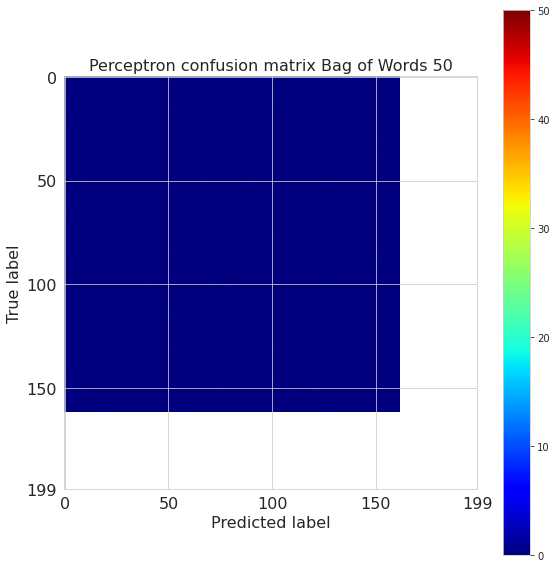


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,1
6,0.0,1
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


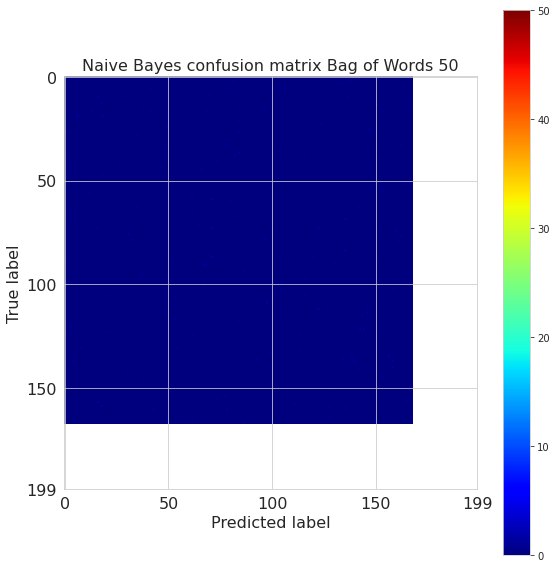


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


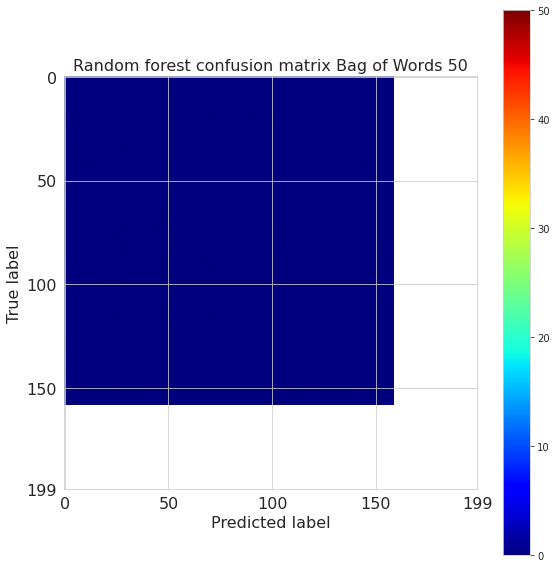


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


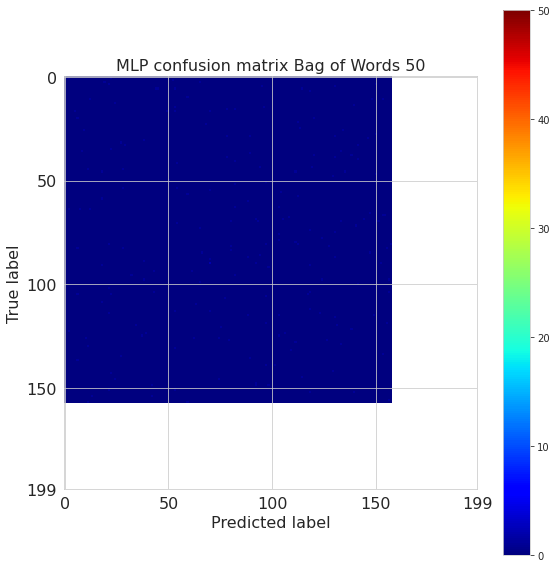


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


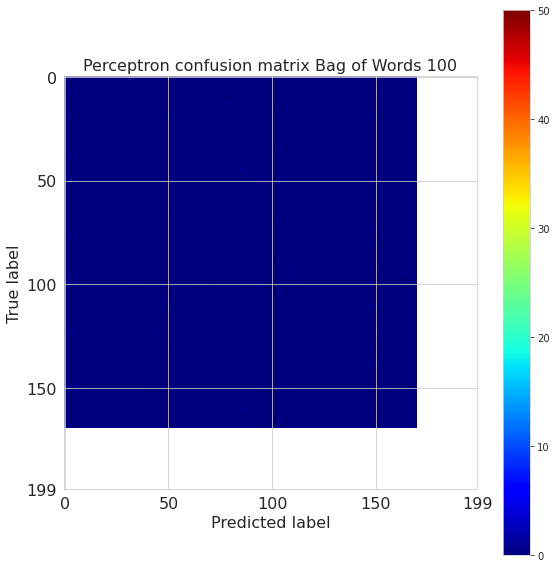


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


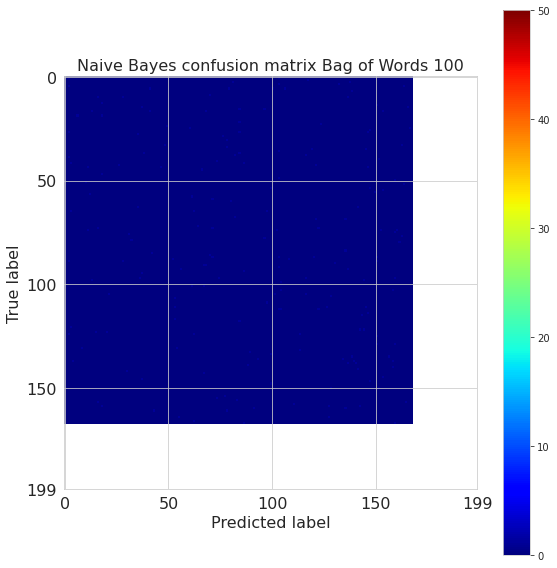


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


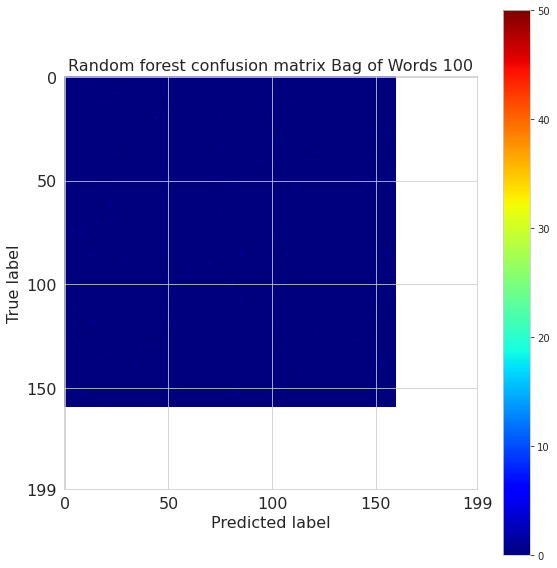


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


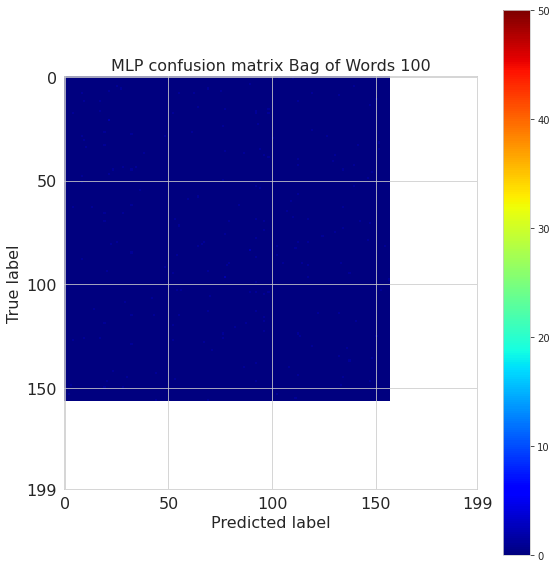


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,1
5,0.0,1
6,0.0,1
7,0.0,1
8,0.0,1
9,0.0,2



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


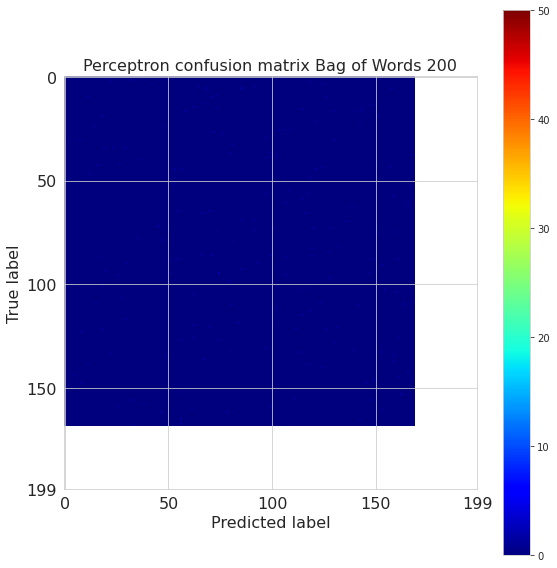


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


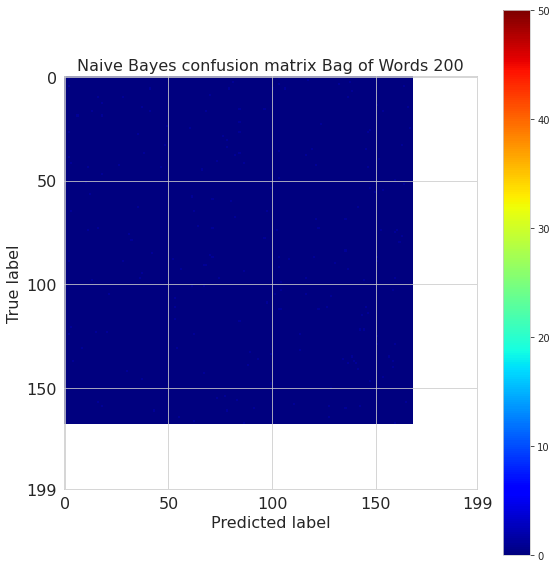


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,1,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


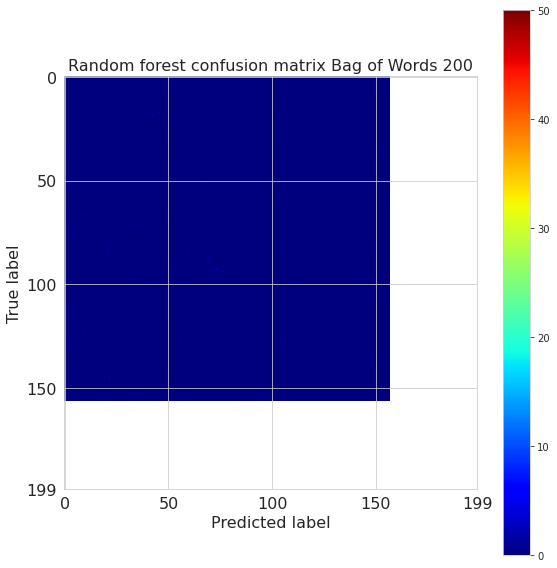


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,2



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,2,0.0,0.0
2,2,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


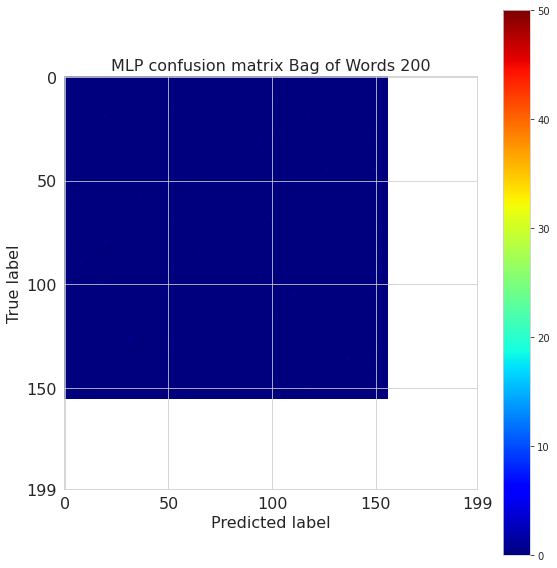


 least correct predictions


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0



 most correct predictions, labels, times correct predicted:


,label,times correct predicted
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,1
8,0.0,1
9,0.0,1



 most confused labels:


,times confused,actual label,predicted label
0,2,0.0,0.0
1,1,0.0,0.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,0.0
5,1,0.0,0.0
6,1,0.0,0.0
7,1,0.0,0.0
8,1,0.0,0.0
9,1,0.0,0.0



 biggest std for column (for which classes the cnn was not very percice):


,0,1,2,3,4,5,6,7,8,9
times label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0.025, 0.015, 0.005]
[0.01, 0.01, 0.01]
[0.015, 0.01, 0.01]
[0.015, 0.035, 0.015]


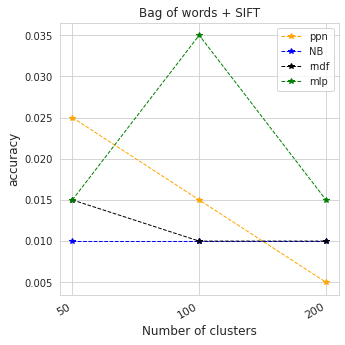

In [181]:
# Classification

scores_ppn, scores_NB, scores_rndf, scores_mlp = [], [], [], []

for i in range(len(Xs)):
    label = str(n_clusters[i])

    X, X_test, y_train, y_test = train_test_split(Xs[i], int_labels(train_labels), test_size=0.2, random_state=42)
    X_nb, X_nb_test, y_nb_train, y_nb_test = train_test_split(mega_histogram, int_labels(train_labels), test_size=0.2, random_state=42)
    trainingLabel=y_train

    times['bow ppn ' + label] = time()
    ppn = create_perceptron(X, trainingLabel)
    times['bow ppn ' + label] = time() - times['bow ppn ' + label]
    y_pred = ppn.predict(X_test)
    scores_ppn.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Perceptron confusion matrix Bag of Words ' + label,
                          saveas="./CM__ppn_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['bow nb ' + label] = time()
    NB = create_nb(X_nb, trainingLabel) # cannot take negative values
    times['bow nb ' + label] = time() - times['bow nb ' + label]
    y_pred = NB.predict(X_nb_test)
    scores_NB.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Naive Bayes confusion matrix Bag of Words ' + label,
                          saveas="./CM__nb_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['bow rndf ' + label] = time()
    rndf = create_rnd_forrest(X, trainingLabel,random_state=42, n_estimators=50)
    times['bow rndf ' + label] = time() - times['bow rndf ' + label]
    y_pred = rndf.predict(X_test)
    scores_rndf.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='Random forest confusion matrix Bag of Words ' + label,
                          saveas="./CM__rndf_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))

    times['bow mlp ' + label] = time()
    mlp = create_MLP(X, trainingLabel)
    times['bow mlp ' + label] = time() - times['bow mlp ' + label]
    y_pred = mlp.predict(X_test)
    scores_mlp.append(accuracy_score(y_test, y_pred))
    plot_confusion_matrix_TIN(confusion_matrix(y_test, y_pred),
                          title='MLP confusion matrix Bag of Words ' + label,
                          saveas="./CM__mlp_"+label)
    analyze_predictions_TIN(confusion_matrix(y_test, y_pred))
    
print(scores_ppn)
print(scores_NB)
print(scores_rndf)
print(scores_mlp)


Nr_data = np.arange(len(n_clusters))
plt.figure(figsize=(5,5))
plt.plot(Nr_data, scores_ppn,"--",color="orange",marker="*", linewidth=1,label="ppn")
plt.plot(Nr_data, scores_NB,"--",color="blue",marker="*", linewidth=1,label="NB")
plt.plot(Nr_data, scores_rndf,"--",color="black",marker="*", linewidth=1,label="rndf")
plt.plot(Nr_data, scores_mlp,"--",color="green",marker="*", linewidth=1,label="mlp")
plt.legend(loc="best")
plt.title("Bag of words + SIFT",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.xlabel("Number of clusters",fontsize=12)
labels = n_clusters
plt.xticks(Nr_data, labels,rotation=30,fontsize=11, ha="right")
plt.savefig("./Accuracy_BOW.pdf")

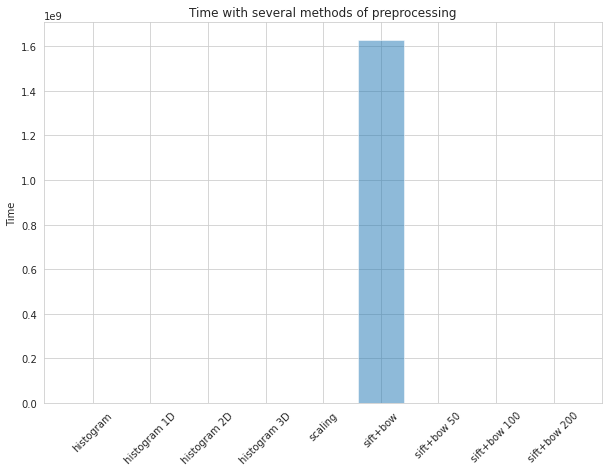

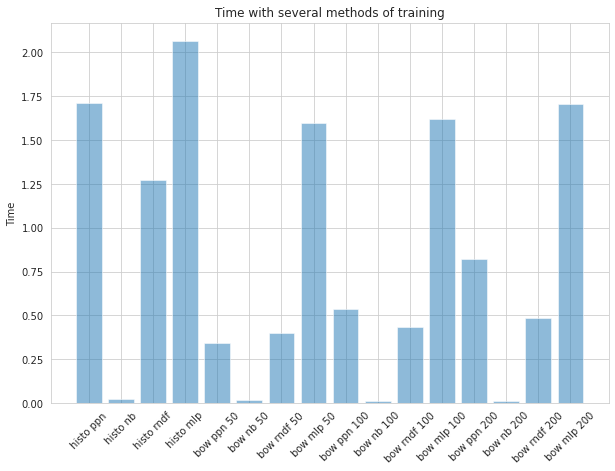

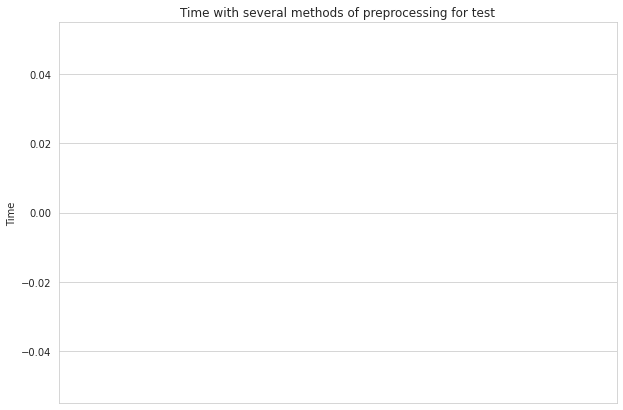

In [182]:
objects = times_prepro.keys()
y_pos = np.arange(len(objects))
scores = times_prepro.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing')

plt.savefig("./time_prepro.pdf")
plt.show()

objects = times.keys()
y_pos = np.arange(len(objects))
scores = times.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of training')

plt.savefig("./time_training.pdf")
plt.show()

objects = times_test.keys()
y_pos = np.arange(len(objects))
scores = times_test.values()

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Time')
plt.title('Time with several methods of preprocessing for test')

plt.savefig("./time_training_test.pdf")
plt.show()